### Курсовая работа. Классическое машинное обучение
### Раздел 2.1. Регрессия для IC50

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [48]:
# Загрузить данные
df = pd.read_csv('ic50.csv')
display(df.head())
print(df.shape)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM"
0,-1.660292,1.160311,0.838612,-0.700360,1.055009,0.205849,-1.502148,1.494888,-2.031080,-0.565772,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,2.267263,-0.078039,6.239374
1,-1.993065,2.006622,0.939393,-0.491142,1.237252,0.236943,-1.706545,1.236198,-2.181446,-0.555914,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,2.267263,-0.078039,0.771831
2,-2.385072,2.060654,0.945827,-1.425902,0.995923,0.685190,-1.061511,1.077899,-2.369403,-0.531481,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,2.267263,-0.078039,223.808778
3,-1.659333,1.179805,0.840933,-0.883631,0.969976,0.314024,-1.502148,1.494888,-2.124410,-0.565840,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,3.083280,-0.078039,1.705624
4,-1.643718,0.486530,0.758377,-0.646206,0.543590,0.838696,-1.312738,1.967023,-2.211519,-0.565202,...,-0.222073,-0.09245,-0.09245,-0.034816,0.0,-0.259198,-0.272254,-0.180788,-0.078039,107.131532


(826, 146)


In [34]:
SEED = 42

In [35]:
# Разделить данные на признаки и целевую переменную
X = df.drop('IC50, mM', axis=1)
y = df['IC50, mM']

# Разделить данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (578, 145), (578,)
Train dataset size: (248, 145), (248,)


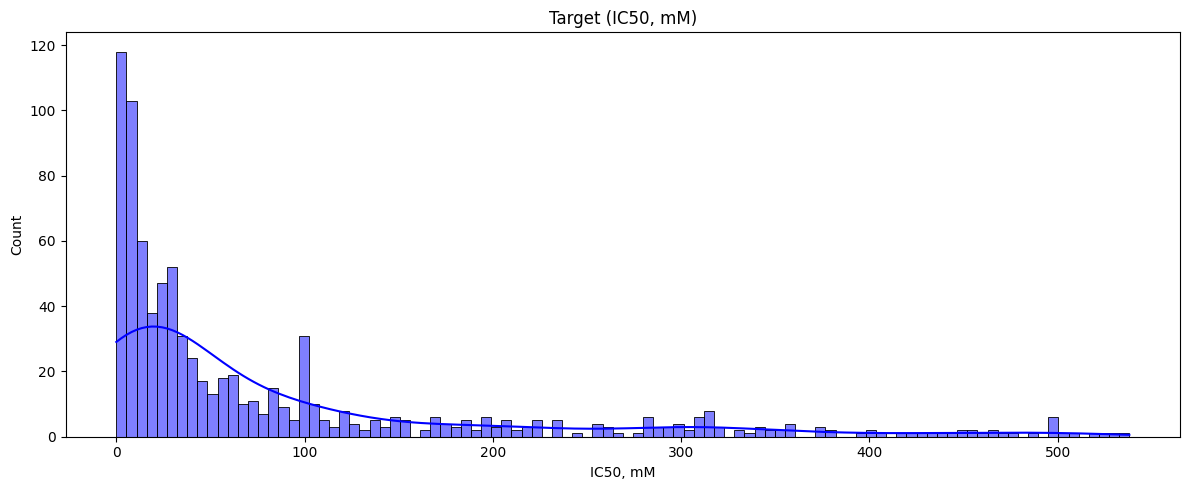

In [36]:
plt.figure(figsize=(12, 5))
sns.histplot(y, kde=True, bins=100, color='blue')
plt.title('Target (IC50, mM)')
plt.tight_layout()
plt.show()

В рамках настоящей задачи будем использовать следующие модели:
- Линейные модели (`Lasso`, `Ridge`, `ElasticNet`);
- `RandomForest`;
- `SVR`;
- `XGBoostRegressor`;
- `CatBoostRegressor`.
  
Для анализа эффективности моделей проверим следующие метрики:
- $MAE$;
- $MAPE$;
- $MSE$;
- $R^2$.

Для подбора наиболее оптимальных гиперпараметров воспользуемся поиском по сетке (`GridSearch`).

In [37]:
metrics = {
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error',
    'MSE': 'neg_mean_squared_error'
}
results = {}

**1. Lasso**

In [38]:
params_lr = {'alpha': [0.01, 0.1, 1, 2, 3, 4, 5, 10, 20, 50, 100]}

# Найти приемлимый alpha с помощью GridSearchCV
grid_lasso = GridSearchCV(Lasso(max_iter=10000),
                           param_grid=params_lr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_lasso = grid_lasso.fit(X_train, y_train).best_params_
for param_name, param_values in params_lr.items():
    param = best_params_lasso[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель линейной регрессии
lasso = grid_lasso.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(lasso, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
results['Lasso'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["Lasso"]}')

Лучшее полученное значение alpha: 3
Cross-Validation R2 scores: 0.312
Cross-Validation MAE scores: 66.465
Cross-Validation MAPE scores: 33.276
Cross-Validation MSE scores: 8927.781

{'MAE': 84.16978574675254, 'MAPE': 84.97245794349716, 'R2': 0.09479414645982787, 'MSE': 13764.419730303223}


**2. Ridge**

In [39]:
# Найти приемлимый alpha с помощью GridSearchCV
grid_ridge = GridSearchCV(Ridge(max_iter=10000),
                           param_grid=params_lr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_ridge = grid_ridge.fit(X_train, y_train).best_params_
for param_name, param_values in params_lr.items():
    param = best_params_ridge[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель линейной регрессии
ridge = grid_ridge.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(ridge, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
results['Ridge'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["Ridge"]}')

Лучшее полученное значение alpha: 100
Cross-Validation R2 scores: 0.383
Cross-Validation MAE scores: 62.567
Cross-Validation MAPE scores: 32.640
Cross-Validation MSE scores: 8006.631

{'MAE': 86.68564020766469, 'MAPE': 70.3475593790436, 'R2': 0.05935000982794836, 'MSE': 14303.377771362504}


**3. ElasticNet**

In [40]:
# Найти приемлимый alpha с помощью GridSearchCV
grid_en = GridSearchCV(ElasticNet(max_iter=10000),
                           param_grid=params_lr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_en = grid_en.fit(X_train, y_train).best_params_
for param_name, param_values in params_lr.items():
    param = best_params_en[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель линейной регрессии
elastic = grid_en.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(elastic, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
results['ElasticNet'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["ElasticNet"]}')

Лучшее полученное значение alpha: 1
Cross-Validation R2 scores: 0.323
Cross-Validation MAE scores: 65.942
Cross-Validation MAPE scores: 34.548
Cross-Validation MSE scores: 8788.591

{'MAE': 84.43770146061838, 'MAPE': 89.82132252594226, 'R2': 0.08842776374522565, 'MSE': 13861.225957864415}


**4. Random Forest**

In [41]:
params_rf = {
    'n_estimators': [50, 100, 150, 200, 300, 400],
    'max_depth': [5, 6, 7, 10, 20, 30]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=SEED),
                           param_grid=params_rf,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_rf = grid_rf.fit(X_train, y_train).best_params_
for param_name, param_values in params_rf.items():
    param = best_params_rf[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель Random Forest
best_rf = grid_rf.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_rf, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["Random Forest"]}')

Лучшее полученное значение n_estimators: 400
Лучшее полученное значение max_depth: 5
Cross-Validation R2 scores: 0.601
Cross-Validation MAE scores: 53.200
Cross-Validation MAPE scores: 26.883
Cross-Validation MSE scores: 5171.105

{'MAE': 82.72676284530138, 'MAPE': 90.42670874454664, 'R2': 0.11751438648470236, 'MSE': 13418.939286432309}


**5. SVR**

In [42]:
params_svr = {
    'C': [10, 20, 30, 50, 100, 200],
    'epsilon': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}

grid_svr = GridSearchCV(SVR(),
                           param_grid=params_svr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_svr = grid_svr.fit(X_train, y_train).best_params_
for param_name, param_values in params_svr.items():
    param = best_params_svr[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель SVR
best_svr = grid_svr.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_svr, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_svr.fit(X_train, y_train)
y_pred = best_svr.predict(X_test)
results['SVR'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["SVR"]}')

Лучшее полученное значение C: 100
Лучшее полученное значение epsilon: 10
Cross-Validation R2 scores: 0.377
Cross-Validation MAE scores: 46.147
Cross-Validation MAPE scores: 8.393
Cross-Validation MSE scores: 8094.902

{'MAE': 71.84344278571483, 'MAPE': 28.33387343707962, 'R2': 0.06488100549386433, 'MSE': 14219.274309620167}


**6. XGBoost**

In [43]:
params_xgb = {
    'n_estimators': [10, 20, 25, 50, 100, 150, 200, 300],
    'learning_rate': [0.001, 0.025, 0.075, 0.01, 0.025, 0.05, 0.1]
}

grid_xgb = GridSearchCV(XGBRegressor(random_state=SEED),
                           param_grid=params_xgb,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_xgb = grid_xgb.fit(X_train, y_train).best_params_
for param_name, param_values in params_xgb.items():
    param = best_params_xgb[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель XGBoost
best_xgb = grid_xgb.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_xgb, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
results['XGBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["XGBoost"]}')

Лучшее полученное значение n_estimators: 10
Лучшее полученное значение learning_rate: 0.1
Cross-Validation R2 scores: 0.629
Cross-Validation MAE scores: 50.145
Cross-Validation MAPE scores: 29.815
Cross-Validation MSE scores: 4801.739

{'MAE': 82.27685708350069, 'MAPE': 113.22062899066155, 'R2': 0.09628607997945415, 'MSE': 13741.733620736508}


**7. CatBoost**

In [44]:
params_cat = {
    'n_estimators': [10, 20, 25, 50, 100, 150, 200],
    'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
}

grid_cat = GridSearchCV(CatBoostRegressor(random_state=SEED),
                           param_grid=params_cat,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_cat = grid_cat.fit(X_train, y_train).best_params_
for param_name, param_values in params_cat.items():
    param = best_params_cat[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель CatBoost
best_cat = grid_cat.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_cat, X_train, y_train, cv=5, scoring=score_func, return_train_score=True, n_jobs=-1)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_cat.fit(X_train, y_train)
y_pred = best_cat.predict(X_test)
results['CatBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["CatBoost"]}')

0:	learn: 111.8133697	total: 6.02ms	remaining: 295ms
1:	learn: 109.5995965	total: 11.8ms	remaining: 284ms
2:	learn: 107.7195308	total: 17.1ms	remaining: 269ms
3:	learn: 106.5355568	total: 22.4ms	remaining: 258ms
4:	learn: 105.2947878	total: 27.2ms	remaining: 245ms
5:	learn: 103.8323322	total: 32.6ms	remaining: 239ms
6:	learn: 102.8158153	total: 38.1ms	remaining: 234ms
7:	learn: 101.2299262	total: 43.3ms	remaining: 227ms
8:	learn: 100.3277807	total: 48.4ms	remaining: 221ms
9:	learn: 99.3683057	total: 53.5ms	remaining: 214ms
10:	learn: 98.2729395	total: 58.7ms	remaining: 208ms
11:	learn: 96.8537250	total: 64.3ms	remaining: 204ms
12:	learn: 95.7067038	total: 69.3ms	remaining: 197ms
13:	learn: 95.0251426	total: 74.6ms	remaining: 192ms
14:	learn: 94.7230067	total: 79.4ms	remaining: 185ms
15:	learn: 93.7440011	total: 84.5ms	remaining: 180ms
16:	learn: 93.1632591	total: 89.7ms	remaining: 174ms
17:	learn: 92.2187560	total: 94.8ms	remaining: 168ms
18:	learn: 91.9575322	total: 100ms	remaining: 1

In [45]:
# Вывод результатов
print(f"{'Model':<20} | {'MAE':<8} | {'MAPE':<8} | {'R2':<6} | {'MSE':<8}")
print("-"*60)
for model, metrics in results.items():
    print(f"{model:<20} | {metrics['MAE']:.4f} |{metrics['MAPE']:.4f} | {metrics['R2']:.4f} | {metrics['MSE']:.4f}")

Model                | MAE      | MAPE     | R2     | MSE     
------------------------------------------------------------
Lasso                | 84.1698 |84.9725 | 0.0948 | 13764.4197
Ridge                | 86.6856 |70.3476 | 0.0594 | 14303.3778
ElasticNet           | 84.4377 |89.8213 | 0.0884 | 13861.2260
Random Forest        | 82.7268 |90.4267 | 0.1175 | 13418.9393
SVR                  | 71.8434 |28.3339 | 0.0649 | 14219.2743
XGBoost              | 82.2769 |113.2206 | 0.0963 | 13741.7336
CatBoost             | 80.3522 |53.7550 | 0.1475 | 12963.3327


In [46]:
# Вывод лучших гиперпараметров
print('Lasso: ', best_params_lasso)
print('Ridge: ', best_params_ridge)
print('ElasticNet: ', best_params_en)
print('Random Forest: ', best_params_rf)
print('SVR: ', best_params_svr)
print('XGBoost: ', best_params_xgb)
print('CatBoost: ', best_params_cat)

Lasso:  {'alpha': 3}
Ridge:  {'alpha': 100}
ElasticNet:  {'alpha': 1}
Random Forest:  {'max_depth': 5, 'n_estimators': 400}
SVR:  {'C': 100, 'epsilon': 10}
XGBoost:  {'learning_rate': 0.1, 'n_estimators': 10}
CatBoost:  {'learning_rate': 0.1, 'n_estimators': 50}


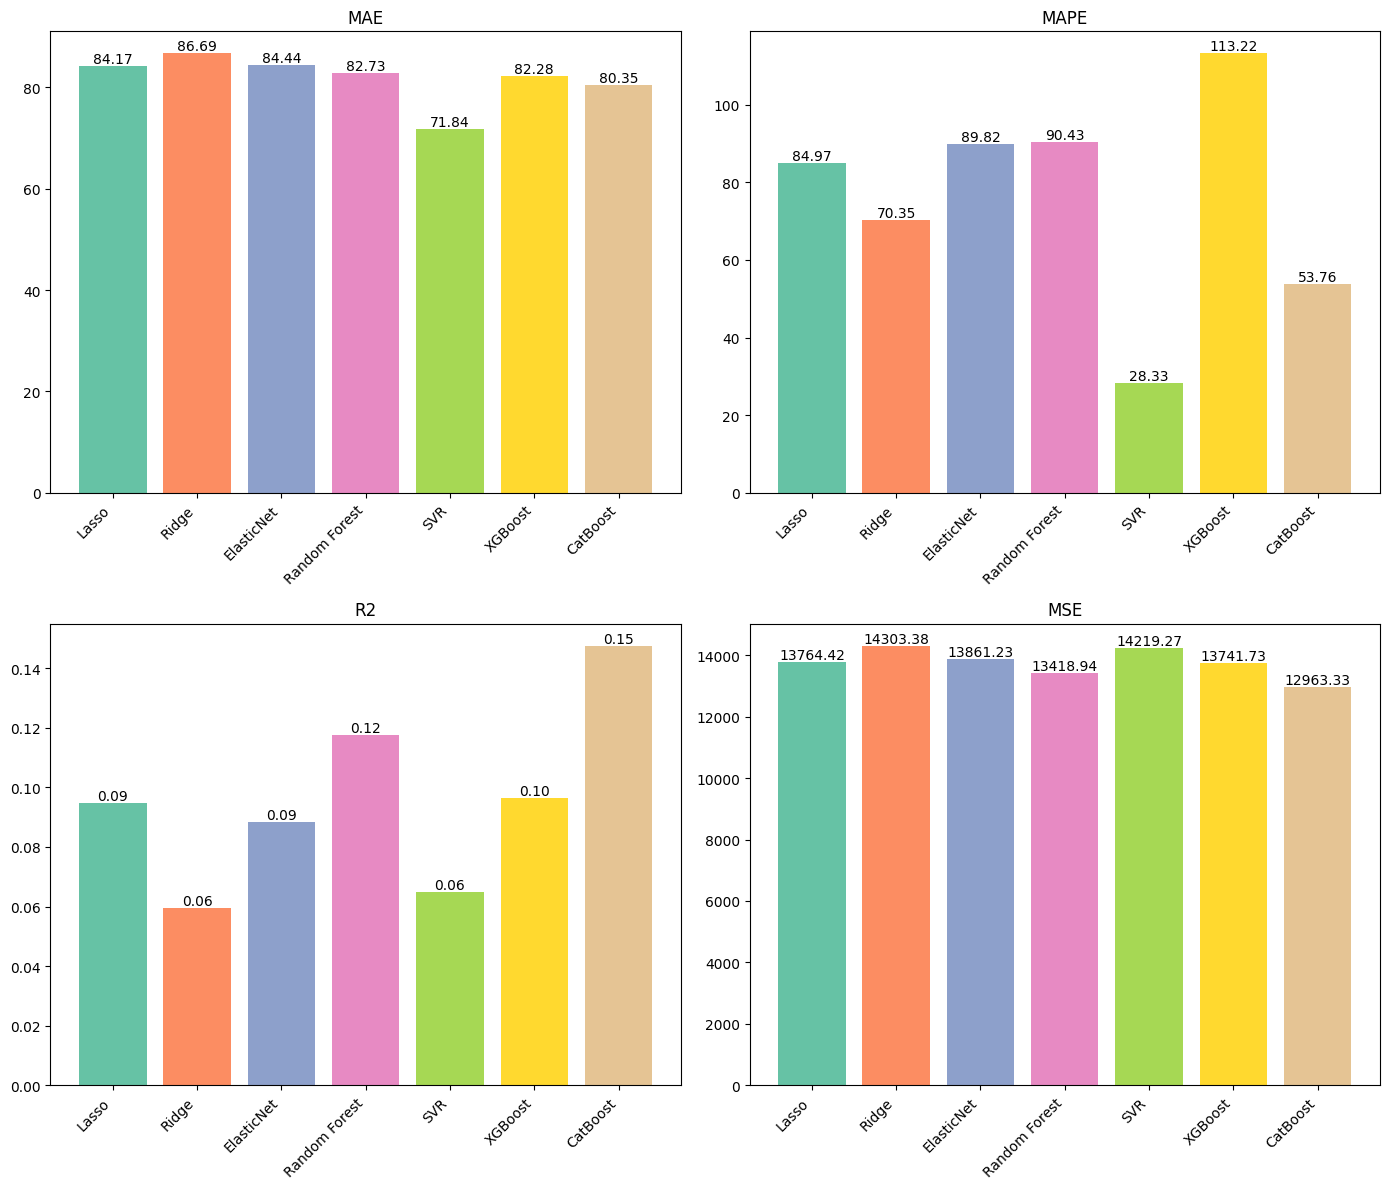

In [47]:
# Построить графики результатов
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
palette = sns.color_palette("Set2", len(results))

for i, metric in enumerate(list(metrics.keys())):
    ax = axes[i // 2, i % 2]
    
    models = list(results.keys())
    values = [results[model][metric] for model in models]
    bars = ax.bar(models, values, color=palette)
    ax.set_title(metric)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Выводы**  
  
1. В рамках настоящей задачи были рассмотрены следующие модели:
- Линейные модели (`Lasso`, `Ridge`, `ElasticNet`);
- `RandomForest`;
- `SVR`;
- `XGBoostRegressor`;
- `CatBoostRegressor`.
  
   Наиболее оптимальной моделью по совокупности использованных метрик принимается `CatBoost`.
2. Метрики всех моделей оказались недостаточно высокими. В качестве рекомендаций по дальнейшему улучшению предсказательной способности моделей требуется более глубокая обработка исходных данных. Как показал ранее выполненный EDA, в данных присутствует существенное число выбросов, однако для их эффективного устранения требуется знание специфики отрасли и понимание ключевой важности тех или иных признаков, что не было выполнено в настоящей работе.